In [1]:
import pandas as pd
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy
import statistics
import graphviz

%matplotlib inline

font = {'family' : 'bold',
        'size'   : 48}

matplotlib.rc('font', **font)
matplotlib.rc('legend', loc='lower right')


sns.set_context("paper", rc={"font.size":48,
                             "font.family": 'bold',
                             "axes.titlesize":42,
                             "axes.labelsize":42, 
                             "legend.fontsize": 42,
                             "legend.loc": 'lower right',
                             "xtick.labelsize": 30,
                             "ytick.labelsize": 30})  

pl.rcParams['figure.figsize'] = 20, 10

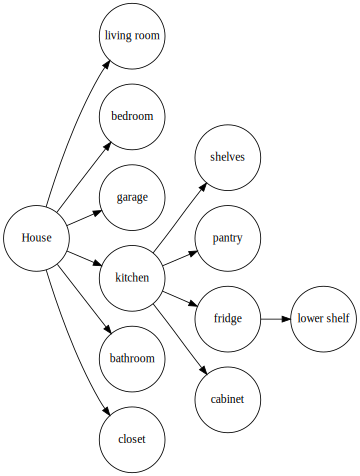

In [82]:
from graphviz import Digraph
d = graphviz.Digraph(filename='viz_oracle.gv')

file = 'search_eval/ours_ours/log.log'
d.attr('node', shape='circle', fixedsize='true', width='1.1')
d.node('House')
d.attr(rankdir='LR',size="5,20")

in_room = None
in_container = None
in_shelf = None
building = False
count = 0
with open(file,'r') as f:
    for line in f:
        if 'Searching in scene graph:' in line:
            count+=1
            if count==1:
                building=True
            continue
        if building:
            indent = sum([c=='\t' for c in line])
            if line.strip()=='---':
                building=False
                break
            if indent == 0:
                in_room = line.strip().replace('_',' ')
                d.node(in_room)
                d.edge('House',in_room)
                container_set = set()
            elif indent == 1:
                if in_room!='kitchen':
                    continue
                in_container = line.strip().replace('_',' ')
                if in_container in container_set:
                    in_container = None
                    continue
                container_set.add(in_container)
                container_node_name = '%s_%s'%(in_room,in_container)
                d.node(container_node_name,label=in_container)
                d.edge(in_room,container_node_name)
            elif indent == 2:
                if in_room!='kitchen' or in_container!='fridge':
                    continue
                in_shelf = line.strip().replace('_',' ')
                shelf_node_name = '%s_%s_%s'%(in_room,in_container,in_shelf)
                d.node(shelf_node_name,label=in_shelf)
                d.edge(container_node_name,shelf_node_name)
            elif indent == 3:
                if in_room!='kitchen' or in_container!='fridge':
                    continue
                obj = line.strip().replace('_','\n')
                object_node_name = '%s_%s_%s_%s'%(in_room,in_container,in_shelf,obj)
                #d.node(object_node_name,color='blue',label=obj)
                #d.edge(shelf_node_name,object_node_name)

d


In [83]:
d.format = 'png'
d.view(filename='shelves', directory='imgs')

'imgs/shelves.png'

In [11]:
file = 'search_eval/ours_ours/log.log'
data = []
count = 0
with open(file,'r') as f:
    for line in f:
        if 'At scene graph' in line:
            parts = line.split('=')
            actions = int(parts[1].split(',')[0])
            data.append({'HMS': actions})
            count+=1
            if count==425:
                break
file = 'search_eval/random_random/log.log'
count = 0
with open(file,'r') as f:
    for line in f:
        if 'At scene graph' in line:
            parts = line.split('=')
            actions = int(parts[1].split(',')[0])
            data[count]['Random'] = actions
            count+=1
            if count==425:
                break

In [97]:
df = pd.DataFrame(data)  

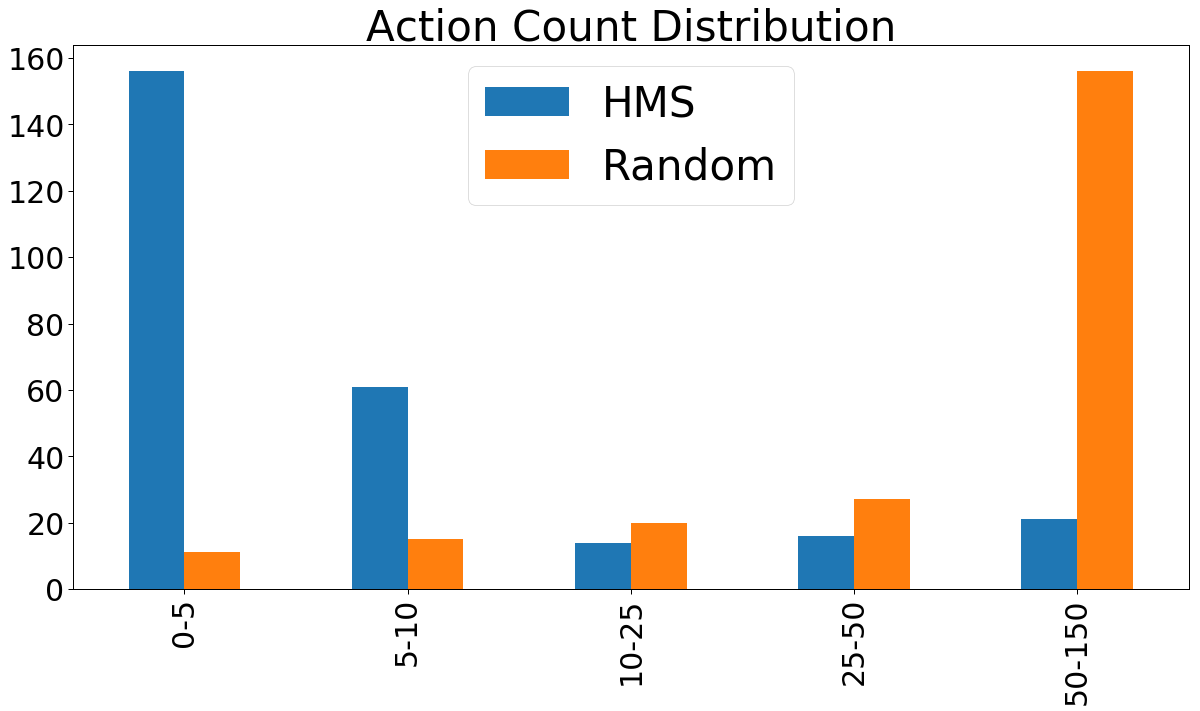

In [108]:
bins = [0,5,10,25,50,150]
labels = ['0-5', '5-10', '10-25', '25-50', '50-150']
df['range_ours'] = pd.cut(df['HMS'], bins, labels=labels)
df['range_random'] = pd.cut(df['Random'], bins, labels=labels)
df2 = pd.DataFrame()  
df2['HMS'] = df.groupby(['range_ours', 'range_random']).size().groupby(level=0).max()
df2['Random'] = df.groupby(['range_ours', 'range_random']).size().groupby(level=1).max()
df2.plot(kind='bar', title='Action Count Distribution')

ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_label_text('foo')
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9953a89d68>,
      dtype=object)

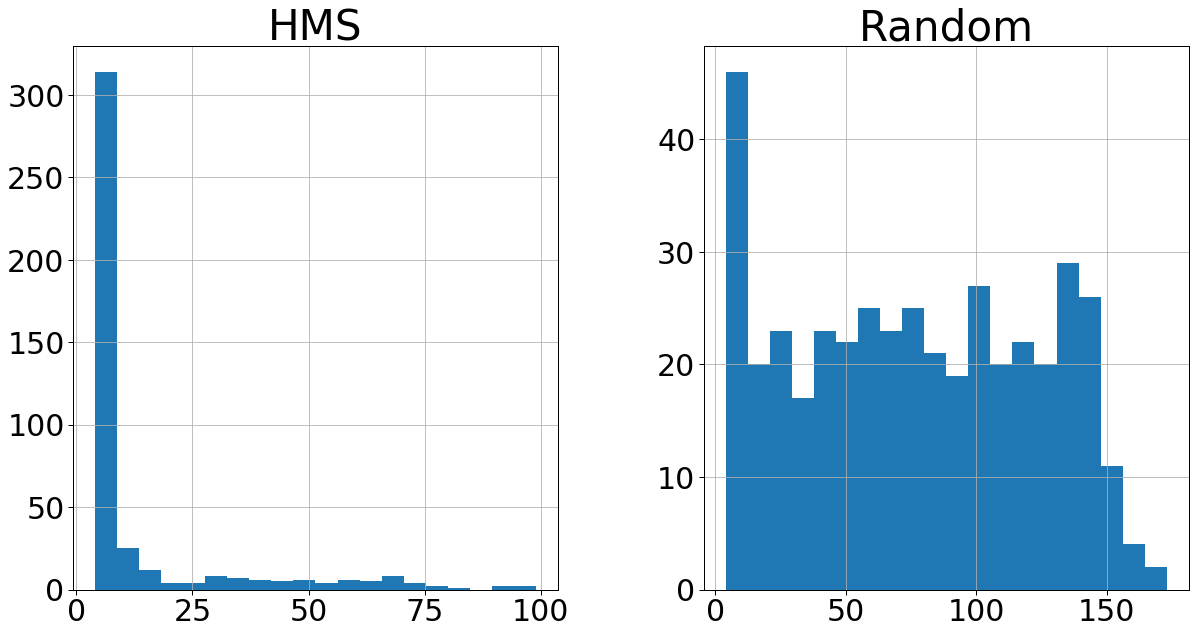

In [101]:
df.hist(bins=20)


In [92]:
files_dir = 'search_eval/'
data = []
for search_eval_dir in sorted(os.listdir(files_dir)):
    log_file = '%s/%s/log.log'%(files_dir, search_eval_dir)
    action_counts = []
    if not os.path.isfile(log_file):
        continue
    count = 0
    with open(log_file,'r') as f:
        for line in f:
            if 'At scene graph' in line:
                count+=1
                graph_num = int(line.split(' ')[6].replace(':',''))
                parts = line.split(',')
                for part in parts:
                    if ' actions=' in part:
                        actions = int(part.split('=')[-1])
                        action_counts.append(actions)
                    if 'total_actions' in part:
                        total_actions = int(part.split('=')[-1])
                if count==500:
                    break
        if action_counts:
            data.append((search_eval_dir, graph_num, total_actions,
                     statistics.mean(action_counts), statistics.median(action_counts)))
for d in data:
    if 'ours_no' not in d[0]:
        print('%s   %d -    %.1f'%(d[0],d[1],d[3]))

most_likely_largest   500 -    17.5
most_likely_nearest   500 -    16.0
most_likely_oracle   500 -    15.3
most_likely_ours   500 -    15.6
most_likely_ours_context_vec   500 -    18.5
most_likely_random   500 -    17.2
oracle_largest   500 -    7.0
oracle_nearest   500 -    5.8
oracle_oracle   500 -    4.3
oracle_ours   500 -    5.4
oracle_ours_context_vec   500 -    7.2
oracle_random   500 -    7.4
ours_context_vec_ours   74 -    13.9
ours_context_vec_ours_context_vec   500 -    18.8
ours_largest   500 -    15.6
ours_nearest   500 -    14.3
ours_oracle   120 -    13.6
ours_ours   500 -    13.8
ours_ours_context_vec   500 -    16.2
ours_random   500 -    14.5
random_largest   373 -    74.6
random_nearest   423 -    80.5
random_oracle   500 -    72.5
random_ours   213 -    73.5
random_ours_context_vec   500 -    79.2
random_random   432 -    76.8
random_word_vec   500 -    75.8
word_vec_largest   500 -    57.6
word_vec_nearest   500 -    58.3
word_vec_oracle   500 -    55.7
word_vec_ou

In [93]:
for d in data:
    if 'ours_no' not in d[0] and d[1]<100:
        print(d)

('ours_context_vec_ours', 74, 1026, 13.864864864864865, 9.5)
